This package implements the basic machinery for decorrelated backpropagation.

In [2]:
import numpy as np
import torch
from src.decorrelation import covariance, DecorrelationPatch2d, DecorrelationFC
import matplotlib.pyplot as plt

We start by showing effective decorrelation of correlated input

iteration 0; average off-diagonal covariance: 0.224246
iteration 1; average off-diagonal covariance: 0.222681
iteration 2; average off-diagonal covariance: 0.221142
iteration 3; average off-diagonal covariance: 0.219627
iteration 4; average off-diagonal covariance: 0.218136
iteration 5; average off-diagonal covariance: 0.216668
iteration 6; average off-diagonal covariance: 0.215222
iteration 7; average off-diagonal covariance: 0.213799
iteration 8; average off-diagonal covariance: 0.212397
iteration 9; average off-diagonal covariance: 0.211016
iteration 10; average off-diagonal covariance: 0.209656
iteration 11; average off-diagonal covariance: 0.208316
iteration 12; average off-diagonal covariance: 0.206996
iteration 13; average off-diagonal covariance: 0.205695
iteration 14; average off-diagonal covariance: 0.204413
iteration 15; average off-diagonal covariance: 0.203149
iteration 16; average off-diagonal covariance: 0.201903
iteration 17; average off-diagonal covariance: 0.200676
it

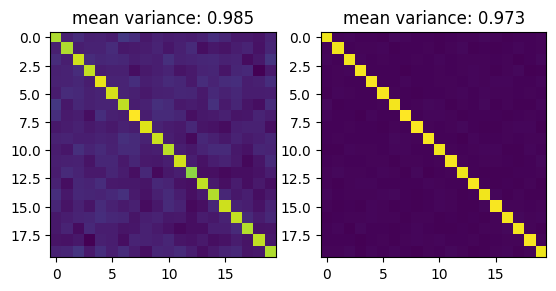

In [3]:
num_samples=1000
num_features=20

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,))

# create a fully connected decorrelator
model = DecorrelationFC(num_features, whiten=True) # NOTE: the whitening constraint is only realised weakly due to the off-diagonal constraints; we observe a weak tendency to unit variance

# covariance matrix before training
A1 = model.covariance(model.forward(data))

# train decorrelator
for i in range(1000):
    y = model.forward(data)
    model.update()
    model.R -= 1e-3 * model.R.grad
    print(f'iteration {i}; average off-diagonal covariance: {covariance([model])[0].numpy():3f}')

# covariance matrix after training
A2 = model.covariance(model.forward(data))

plt.subplot(1,2,1)
plt.imshow(A1)
plt.title(f'mean variance: {torch.mean(torch.diag(A1)):.3f}')
plt.subplot(1,2,2)
plt.imshow(A2)
plt.title(f'mean variance: {torch.mean(torch.diag(A2)):.3f}');


Decorrelation of correlated input represented in convolutional [N, C, H, W] form

iteration 0; average off-diagonal kernel covariance: 0.673770
iteration 1; average off-diagonal kernel covariance: 0.304142
iteration 2; average off-diagonal kernel covariance: 0.223567
iteration 3; average off-diagonal kernel covariance: 0.180206
iteration 4; average off-diagonal kernel covariance: 0.152381
iteration 5; average off-diagonal kernel covariance: 0.132796
iteration 6; average off-diagonal kernel covariance: 0.118178
iteration 7; average off-diagonal kernel covariance: 0.106811
iteration 8; average off-diagonal kernel covariance: 0.097699
iteration 9; average off-diagonal kernel covariance: 0.090222
iteration 10; average off-diagonal kernel covariance: 0.083968
iteration 11; average off-diagonal kernel covariance: 0.078657
iteration 12; average off-diagonal kernel covariance: 0.074089
iteration 13; average off-diagonal kernel covariance: 0.070116
iteration 14; average off-diagonal kernel covariance: 0.066628
iteration 15; average off-diagonal kernel covariance: 0.063542
it

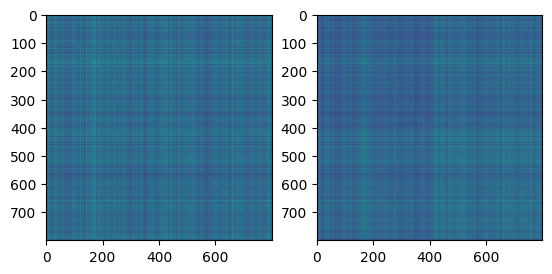

In [4]:
# generate [N, M] correlated input
num_examples=100
num_channels=2
height=20
width=20
num_features=num_channels*height*width
kernel_size=(5,5)

d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
data = d.sample((num_examples,)).reshape(num_examples,num_channels,height,width)

# create a convolutional decorrelator
model = DecorrelationPatch2d(2, kernel_size=kernel_size, whiten=True)

# correlation matrix before training
B1 = DecorrelationFC.covariance(model.forward(data).view(num_examples,-1))

# train decorrelator
for i in range(1000):
    y = model.forward(data)
    model.update()
    model.R -= 1e-2 * model.R.grad
    print(f'iteration {i}; average off-diagonal kernel covariance: {covariance([model])[0].numpy():3f}')

# correlation matrix after training
B2 = DecorrelationFC.covariance(model.forward(data).view(num_examples,-1))

plt.subplot(1,2,1)
plt.imshow(B1)
plt.subplot(1,2,2)
plt.imshow(B2)

# does patchwise not translate into full size????

In [5]:
B1

tensor([[0.7363, 0.6643, 0.6173,  ..., 0.6183, 0.6480, 0.6538],
        [0.6643, 0.8072, 0.6620,  ..., 0.6649, 0.6744, 0.7086],
        [0.6173, 0.6620, 0.6741,  ..., 0.6040, 0.6106, 0.6322],
        ...,
        [0.6183, 0.6649, 0.6040,  ..., 0.7098, 0.6049, 0.6318],
        [0.6480, 0.6744, 0.6106,  ..., 0.6049, 0.7420, 0.6792],
        [0.6538, 0.7086, 0.6322,  ..., 0.6318, 0.6792, 0.7984]])

In [6]:
B2

tensor([[0.0214, 0.0193, 0.0177,  ..., 0.0179, 0.0184, 0.0185],
        [0.0193, 0.0235, 0.0190,  ..., 0.0193, 0.0192, 0.0200],
        [0.0177, 0.0190, 0.0190,  ..., 0.0172, 0.0171, 0.0176],
        ...,
        [0.0179, 0.0193, 0.0172,  ..., 0.0205, 0.0171, 0.0178],
        [0.0184, 0.0192, 0.0171,  ..., 0.0171, 0.0207, 0.0188],
        [0.0185, 0.0200, 0.0176,  ..., 0.0178, 0.0188, 0.0219]])

In [7]:
# MAYBE IT ALREADY WORKS? INPUT DATA SHOULD BE TRANSLATION INVARIANT? THIS IS DEFINITELY NOT THE CASE IN GENERAL... NEEDS MORE THOUGHT

To do:
- annoying path problem; how to solve in vs code
- experiment can be used if current approach works. Do we have any guarantee of decorrelated input if average over patches? and if we take only center pixel? We can check by extracting the patches for the created output again and compute covariances
- reimplement code sander as starting point also for comparison